**Most Frequently Seen Bird**

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import GRU, Dense
import time


file_path = "birds_observation_data_with_index.csv"
df = pd.read_csv(file_path)

# Most frequent bird
bird_counts = df['Bird Name'].value_counts()
most_frequent_bird = bird_counts.index[0]
bird_data = df[df['Bird Name'] == most_frequent_bird]
bird_trend = bird_data.groupby('Date Index')['Number of Birds'].sum()
values = bird_trend.values.astype('float32').reshape(-1, 1)
print("Most frequently seen bird:", most_frequent_bird)

print(values.mean())

# Normalization
values_log = np.log1p(values)  
values_scaled = values_log

Most frequently seen bird: Eurasian Tree Sparrow
64.92135


In [34]:
window_size = 5
# window_size = 10
# window_size = 20
# window_size = 25
# window_size = 30
# window_size = 50

# Sliding Window For Multistep Forecast
def create_multistep_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size]) 
        Y.append(data[i + window_size]) 
    return np.array(X), np.array(Y)

X, Y = create_multistep_dataset(values_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to (samples, time steps, features)

c:\Users\tsimi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training time: 82.84 seconds


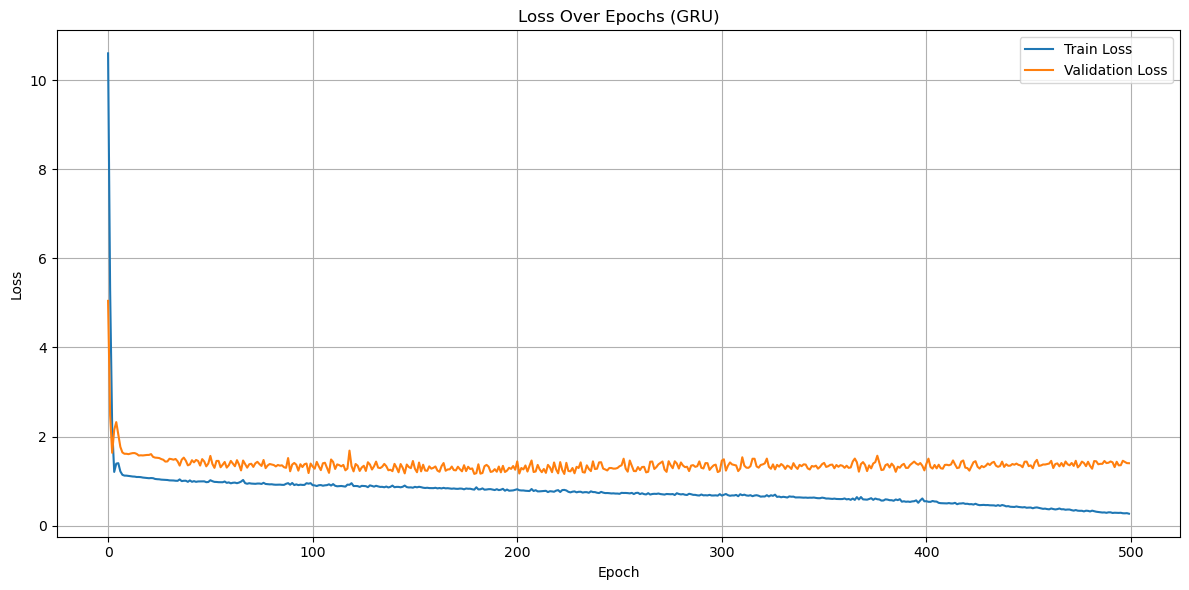

In [35]:
# Train/Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

start = time.time()

model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(window_size, 1)))
model.add(GRU(32)) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, 
                    Y_train, 
                    epochs=500, 
                    verbose=0, 
                    validation_data=(X_test, Y_test)
                    )


print(f"Training time: {time.time() - start:.2f} seconds")

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Save Model**

In [ ]:
# model.save('GRU_bird_model.h5')
# print("Model saved as GRU_bird_model.h5")

**Load Saved Model**

In [ ]:
from tensorflow.keras.models import load_model

# model = load_model('GRU_bird_model.h5')

# **Forecasting for Future Trend**

## **window size of 5**

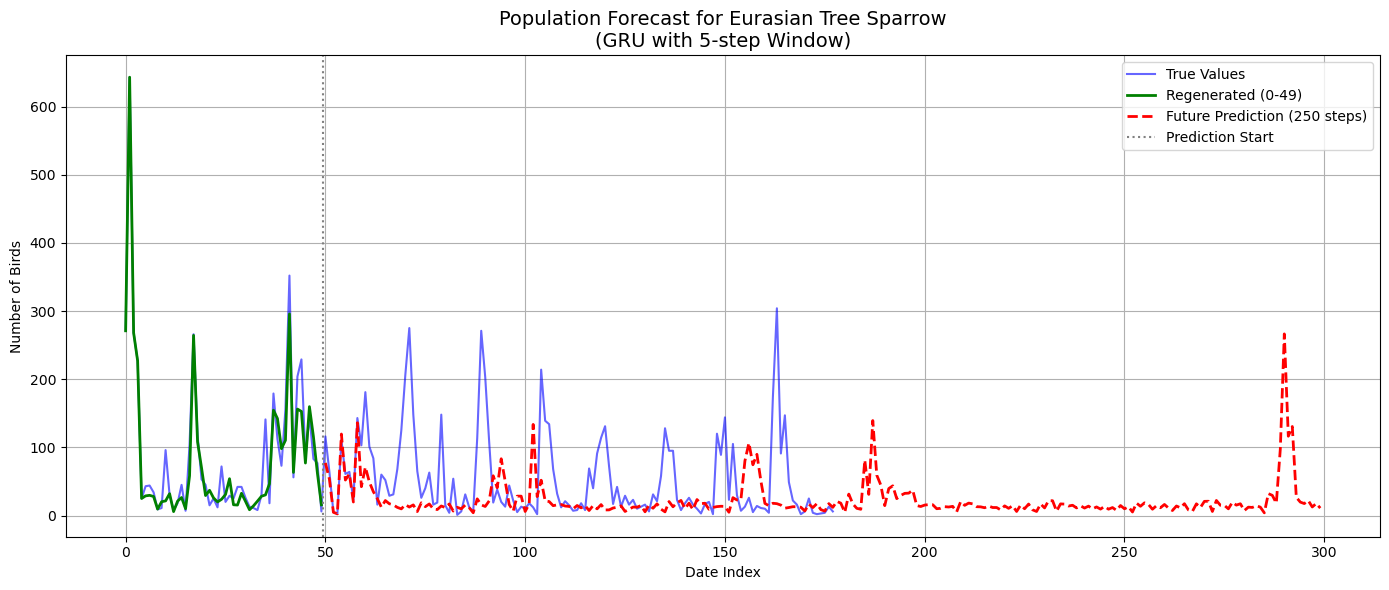

Model Performance Metrics of GRU with 5-step Window:
MSE: 980.7025
RMSE: 31.3162
MAE: 21.2156


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

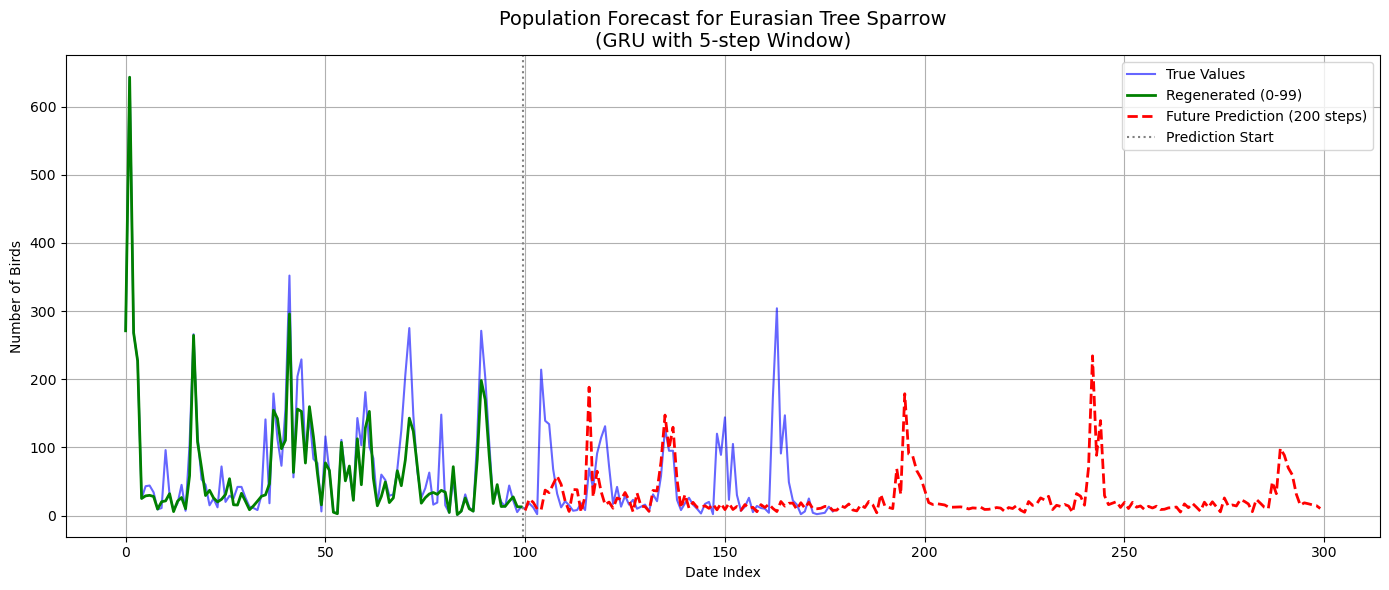

Model Performance Metrics of GRU with 5-step Window:
MSE: 1274.1512
RMSE: 35.6953
MAE: 22.2573


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

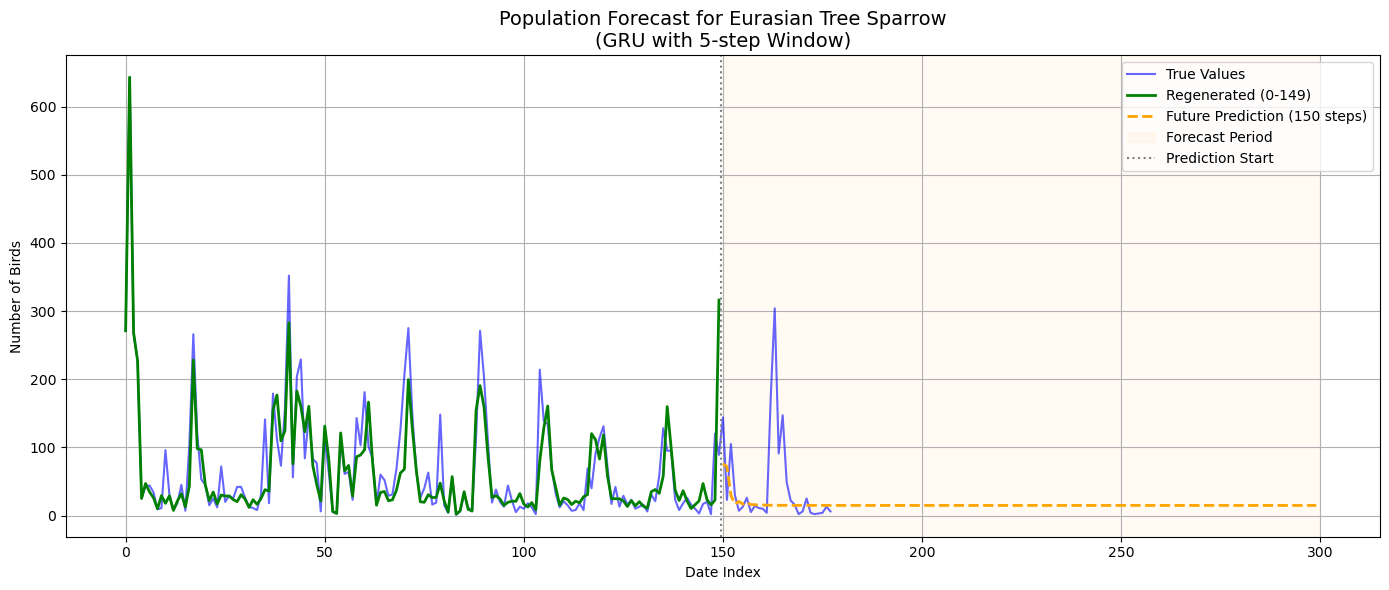

Model Performance Metrics of GRU with 5-step Window:
MSE: 1535.2446
RMSE: 39.1822
MAE: 22.8914
MAPE: 57.86%


In [36]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 



print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


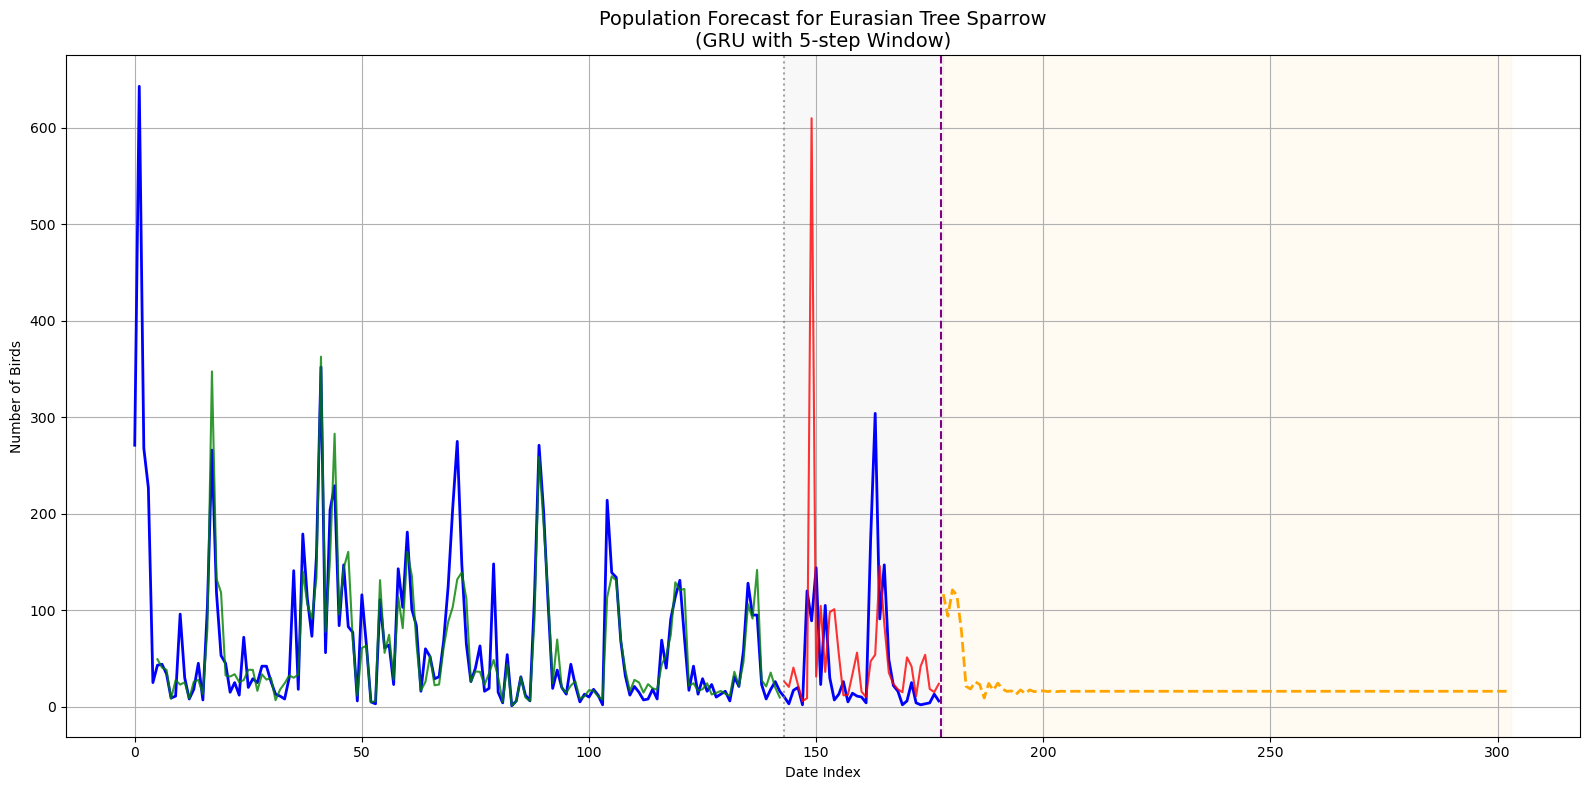


Model Performance Metrics of GRU with 5-step Window:

Traning:

Training RMSE: 30.00
Training MSE: 899.96
Training MAE: 17.54
Training MAPE: 39.93%

Testing:

Test RMSE: 109.50
Test MSE: 11989.75
Test MAE: 56.49
Test MAPE: 326.20%


In [4]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of GRU with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [57]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 25.50
Step 2: 29.10
Step 3: 18.96
Step 4: 67.05
Step 5: 102.76
Step 6: 60.13
Step 7: 149.36
Step 8: 99.32
Step 9: 40.47
Step 10: 7.37
Step 11: 81.43
Step 12: 53.34
Step 13: 3.35
Step 14: 26.17
Step 15: 104.65
Step 16: 17.09
Step 17: 5.42
Step 18: 162.06
Step 19: 21.63
Step 20: 1.43
Step 21: 59.01
Step 22: 13.38
Step 23: 2.75
Step 24: 3.93
Step 25: 36.34
Step 26: 39.83
Step 27: 88.25
Step 28: 35.88
Step 29: 18.99
Step 30: 10.25
Step 31: 16.85
Step 32: 17.88
Step 33: 13.88
Step 34: 13.04
Step 35: 5.65
Step 36: 29.11
Step 37: 28.65
Step 38: 48.12
Step 39: 134.89
Step 40: 97.13
Step 41: 137.42
Step 42: 53.39
Step 43: 12.08
Step 44: 29.13
Step 45: 10.20
Step 46: 21.53
Step 47: 14.61
Step 48: 13.34
Step 49: 13.12
Step 50: 8.99
Step 51: 18.71
Step 52: 13.80
Step 53: 16.75
Step 54: 6.67
Step 55: 13.13
Step 56: 11.06
Step 57: 15.20
Step 58: 11.31
Step 59: 3.98
Step 60: 30.60
Step 61: 26.06
Step 62: 12.17
Step 63: 45.62
Step 64: 157.68
Step 65: 59.37
Step 

## **window size of 10**

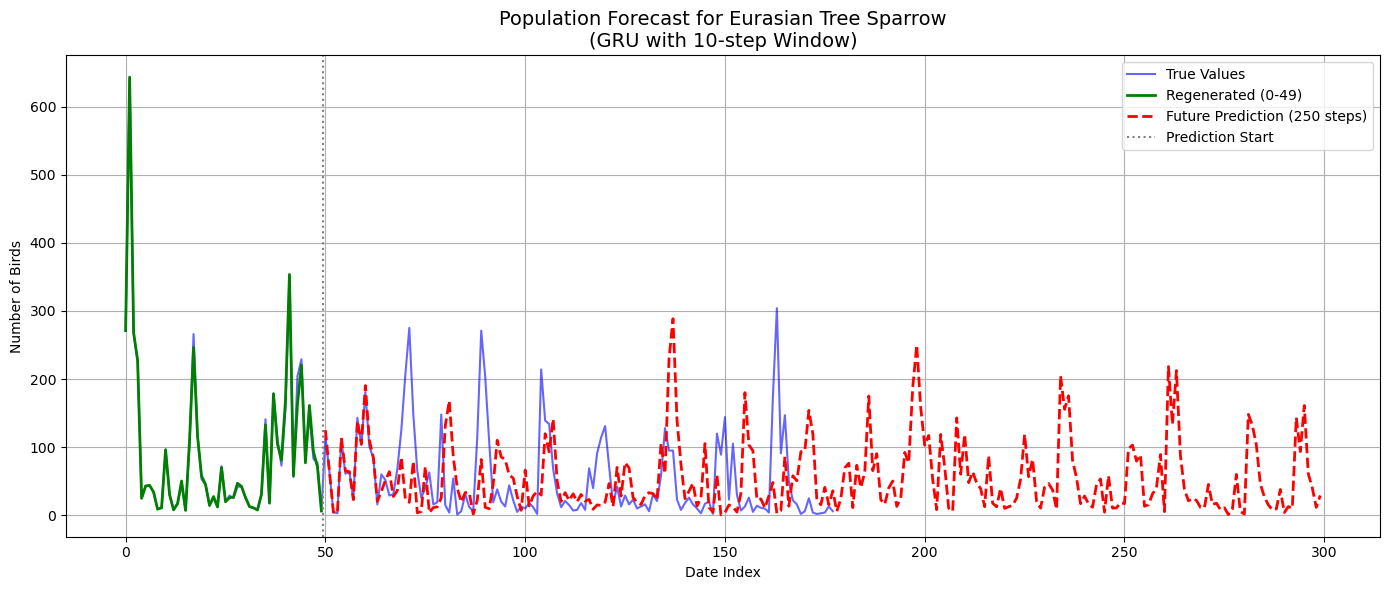

Model Performance Metrics of GRU with 10-step Window:
MSE: 76.0440
RMSE: 8.7203
MAE: 4.6382


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

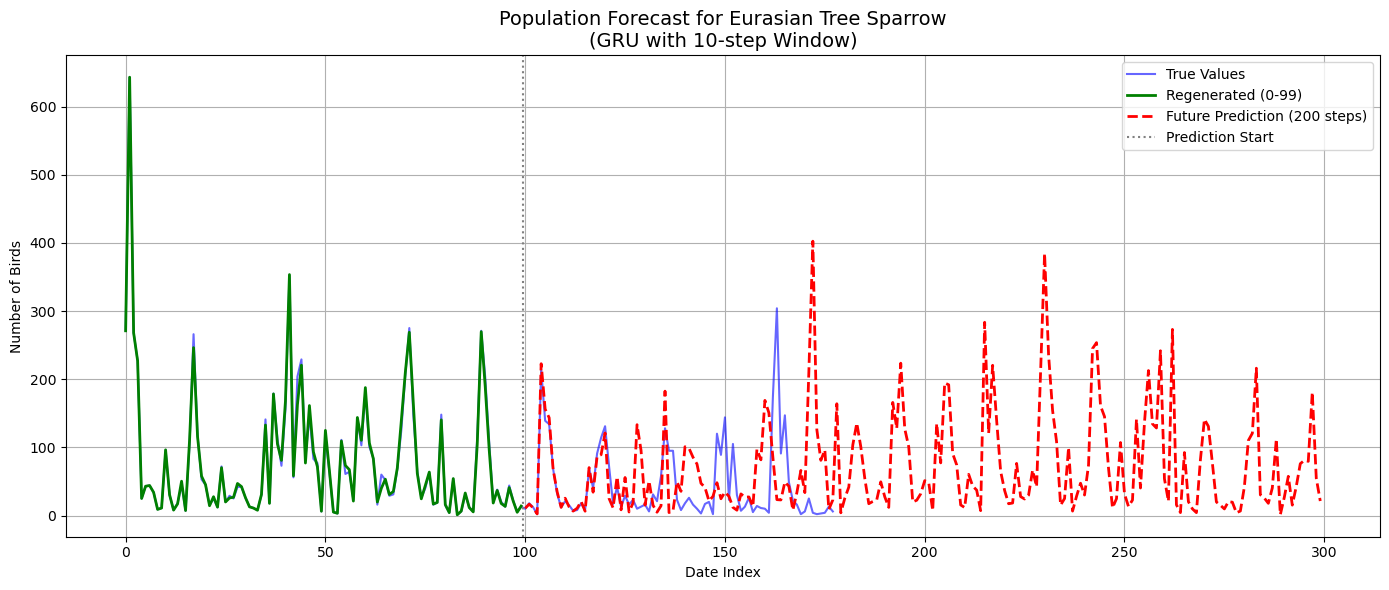

Model Performance Metrics of GRU with 10-step Window:
MSE: 54.7288
RMSE: 7.3979
MAE: 4.2153


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

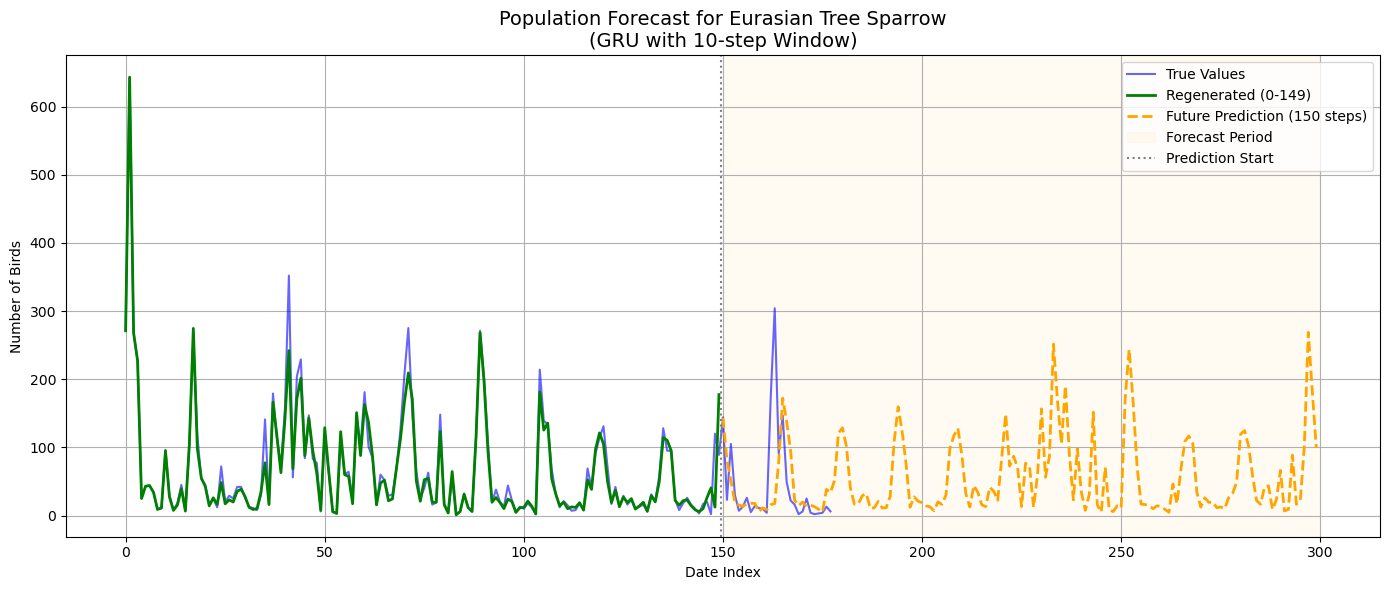

Model Performance Metrics of GRU with 10-step Window:
MSE: 400.9944
RMSE: 20.0248
MAE: 9.7827
MAPE: 29.64%


In [16]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 



print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


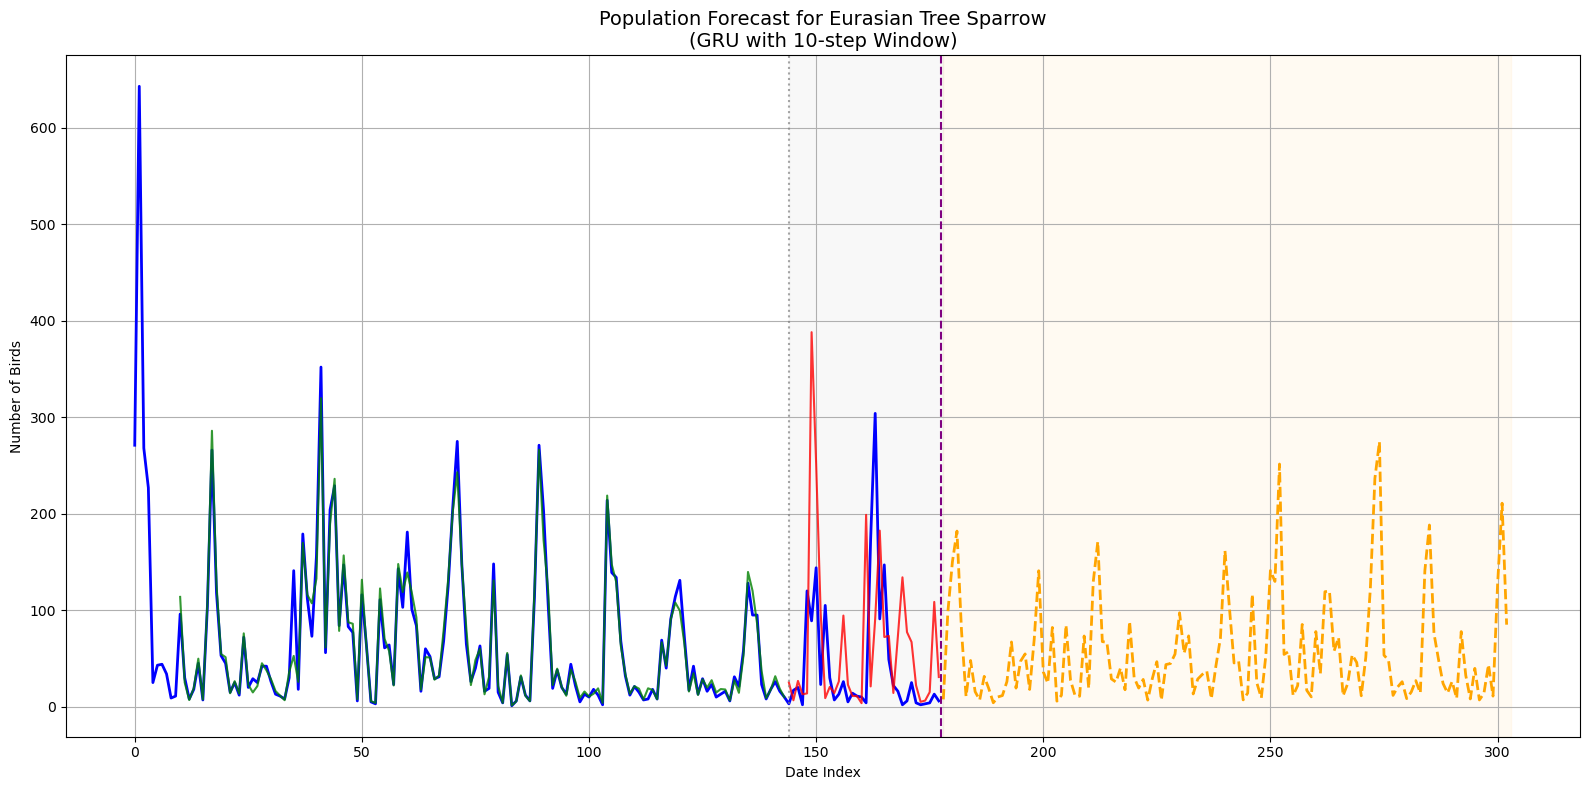


Model Performance Metrics of GRU with 10-step Window:

Traning:

Training RMSE: 12.66
Training MSE: 160.35
Training MAE: 7.10
Training MAPE: 15.71%

Testing:

Test RMSE: 92.72
Test MSE: 8597.33
Test MAE: 61.08
Test MAPE: 557.52%


In [8]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of GRU with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [8]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 0.90
Step 2: 86.50
Step 3: 148.09
Step 4: 109.62
Step 5: 61.09
Step 6: 14.87
Step 7: 23.14
Step 8: 9.34
Step 9: 13.52
Step 10: 32.65
Step 11: 8.60
Step 12: 3.08
Step 13: 177.55
Step 14: 53.75
Step 15: 112.88
Step 16: 83.58
Step 17: 49.61
Step 18: 24.21
Step 19: 12.44
Step 20: 12.40
Step 21: 39.27
Step 22: 52.01
Step 23: 23.18
Step 24: 10.55
Step 25: 95.62
Step 26: 13.31
Step 27: 104.35
Step 28: 96.11
Step 29: 163.09
Step 30: 174.81
Step 31: 159.33
Step 32: 154.91
Step 33: 20.88
Step 34: 52.69
Step 35: 119.88
Step 36: 12.65
Step 37: 8.14
Step 38: 153.85
Step 39: 8.26
Step 40: 4.38
Step 41: 1.37
Step 42: 75.01
Step 43: 18.46
Step 44: 62.77
Step 45: 3.28
Step 46: 136.25
Step 47: 78.83
Step 48: 157.56
Step 49: 111.19
Step 50: 63.23
Step 51: 48.69
Step 52: 11.53
Step 53: 9.96
Step 54: 127.20
Step 55: 15.54
Step 56: 38.57
Step 57: 19.34
Step 58: 205.04
Step 59: 107.01
Step 60: 225.82
Step 61: 59.00
Step 62: 30.80
Step 63: 19.53
Step 64: 45.89
Step 65: 

## **window size of 20**

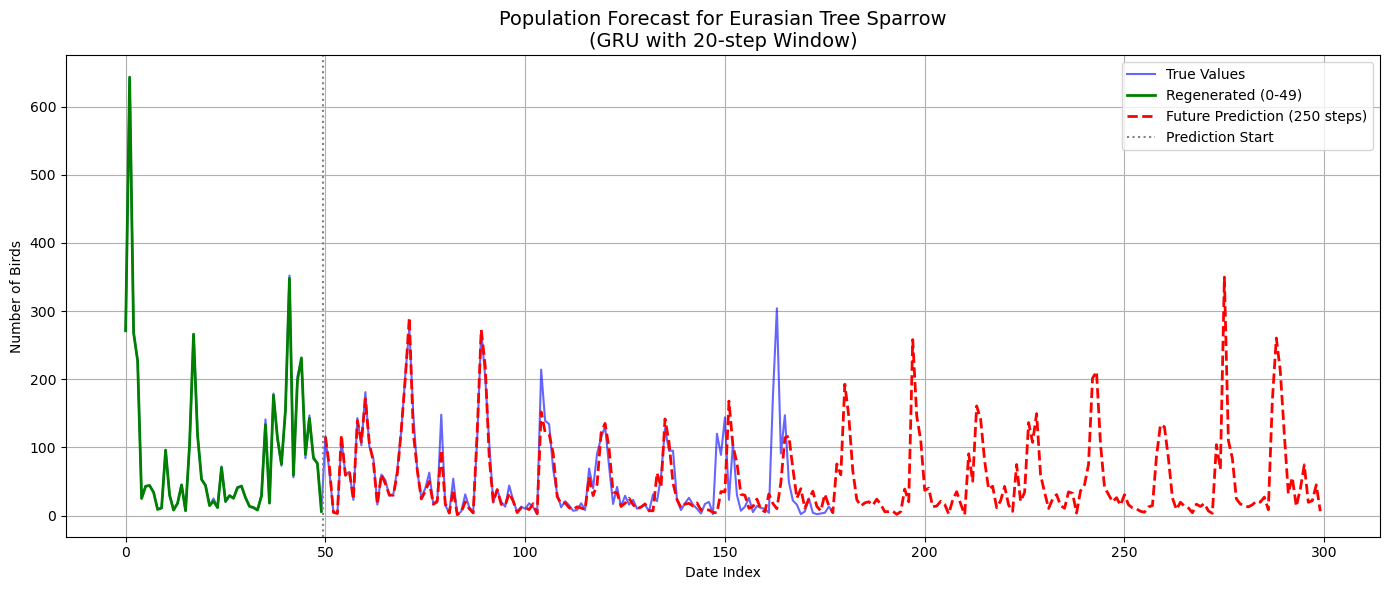

Model Performance Metrics of GRU with 20-step Window:
MSE: 7.7717
RMSE: 2.7878
MAE: 2.0171


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

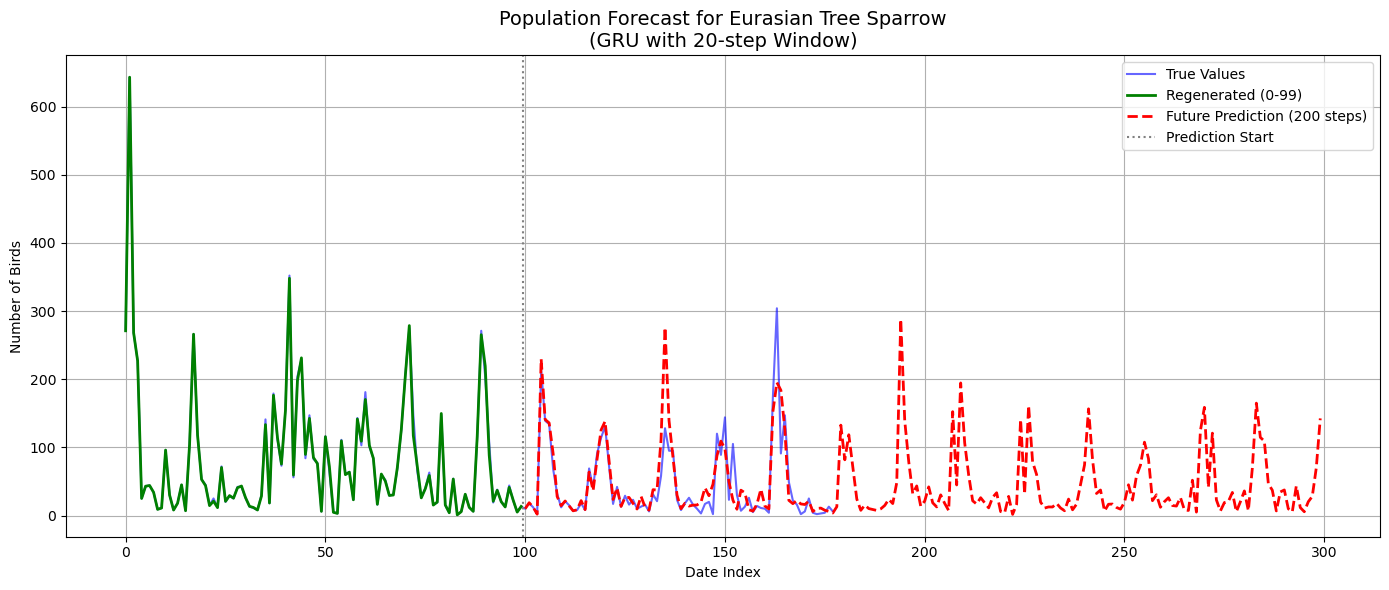

Model Performance Metrics of GRU with 20-step Window:
MSE: 26.9852
RMSE: 5.1947
MAE: 2.5393


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

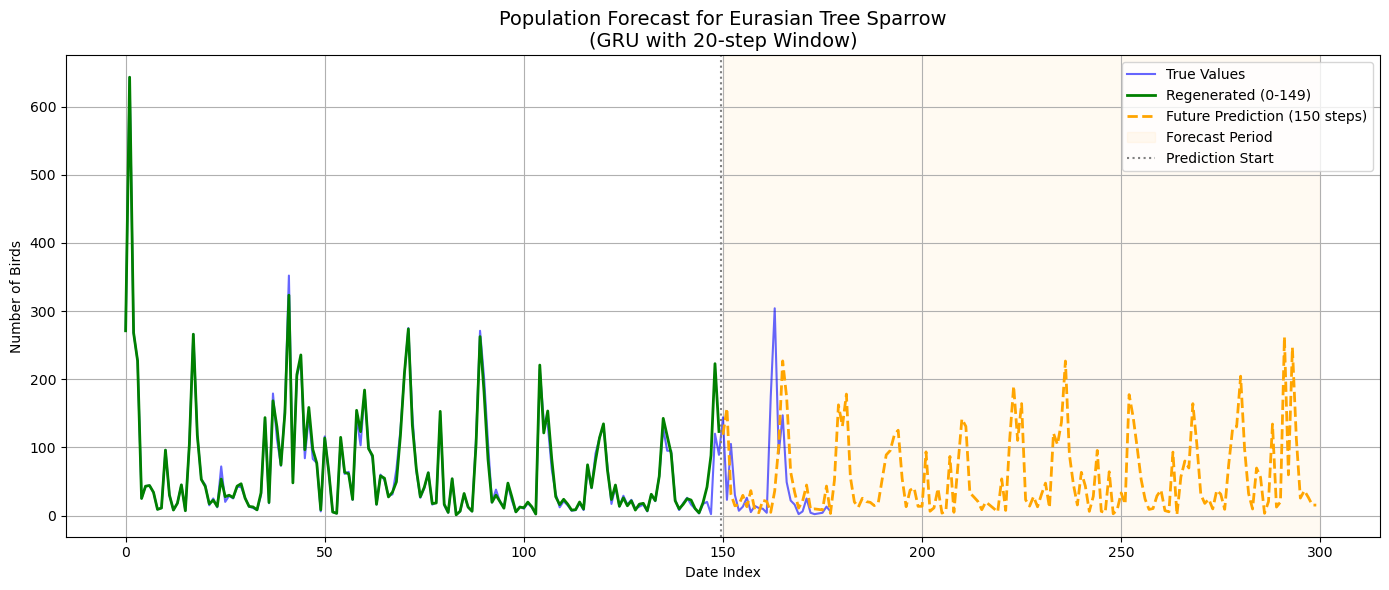

Model Performance Metrics of GRU with 20-step Window:
MSE: 205.5205
RMSE: 14.3360
MAE: 6.3125
MAPE: 44.30%


In [20]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 



print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


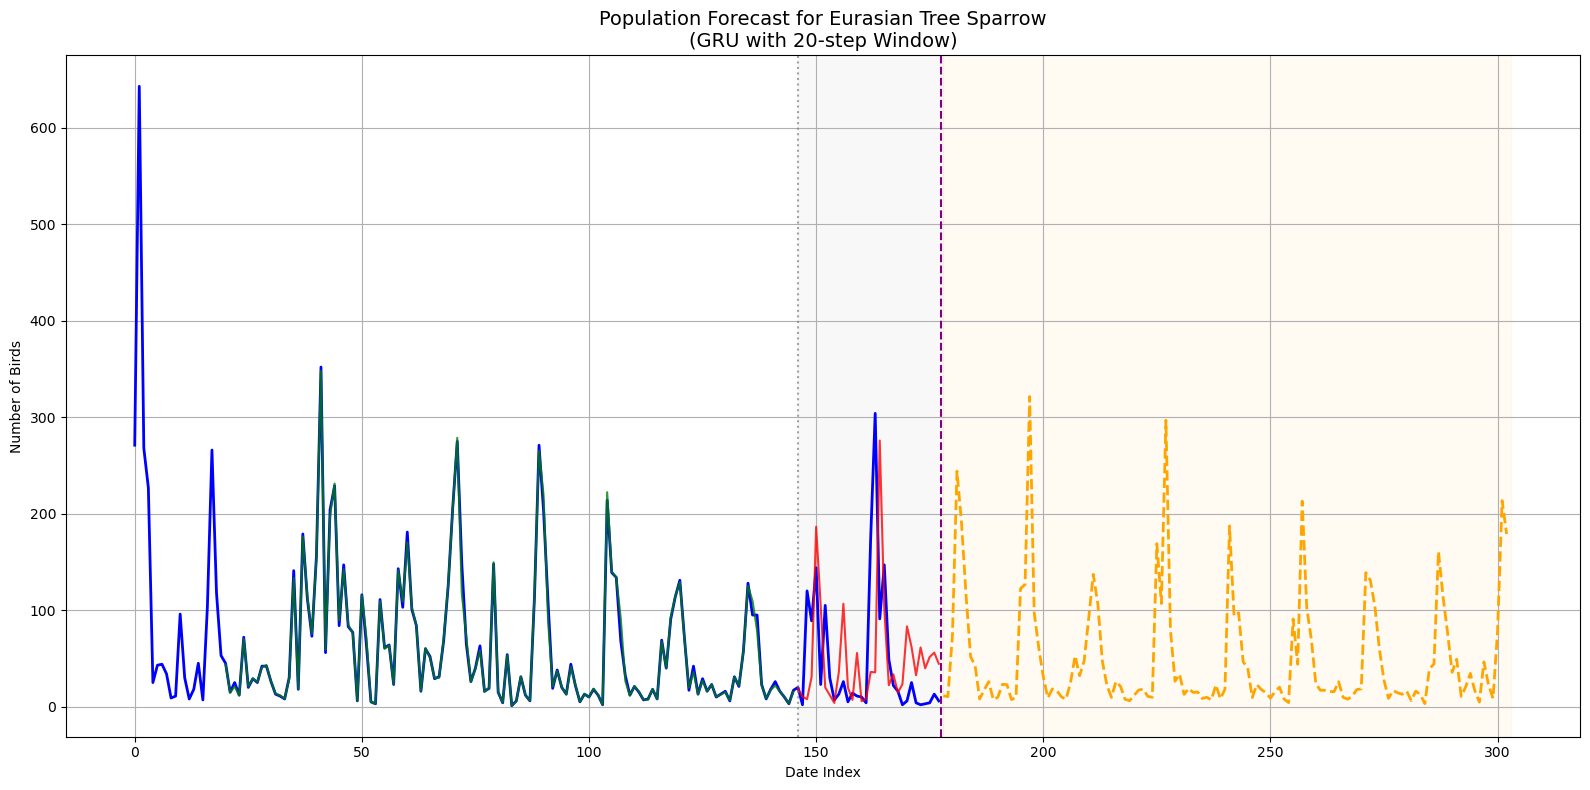


Model Performance Metrics of GRU with {window_size}-step Window:
Training RMSE: 5.17
Test RMSE: 76.78
Training MAE: 2.46
Test MAE: 51.68


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of GRU with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [8]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 11.17
Step 2: 10.45
Step 3: 73.65
Step 4: 244.06
Step 5: 190.86
Step 6: 115.41
Step 7: 51.77
Step 8: 42.37
Step 9: 8.02
Step 10: 17.40
Step 11: 25.98
Step 12: 7.25
Step 13: 9.87
Step 14: 23.19
Step 15: 22.83
Step 16: 7.38
Step 17: 9.54
Step 18: 122.43
Step 19: 126.71
Step 20: 321.36
Step 21: 97.48
Step 22: 61.33
Step 23: 31.22
Step 24: 9.17
Step 25: 18.41
Step 26: 16.47
Step 27: 10.18
Step 28: 7.70
Step 29: 24.87
Step 30: 52.72
Step 31: 32.15
Step 32: 47.51
Step 33: 91.83
Step 34: 137.15
Step 35: 106.99
Step 36: 47.34
Step 37: 22.35
Step 38: 9.67
Step 39: 26.09
Step 40: 21.05
Step 41: 7.64
Step 42: 6.17
Step 43: 11.75
Step 44: 17.25
Step 45: 18.20
Step 46: 10.69
Step 47: 9.82
Step 48: 168.97
Step 49: 106.91
Step 50: 296.83
Step 51: 79.19
Step 52: 26.38
Step 53: 33.72
Step 54: 12.75
Step 55: 18.90
Step 56: 14.75
Step 57: 15.23
Step 58: 8.51
Step 59: 9.69
Step 60: 7.09
Step 61: 22.52
Step 62: 8.17
Step 63: 18.21
Step 64: 187.36
Step 65: 94.10
Step 

## **Window Size of 25**

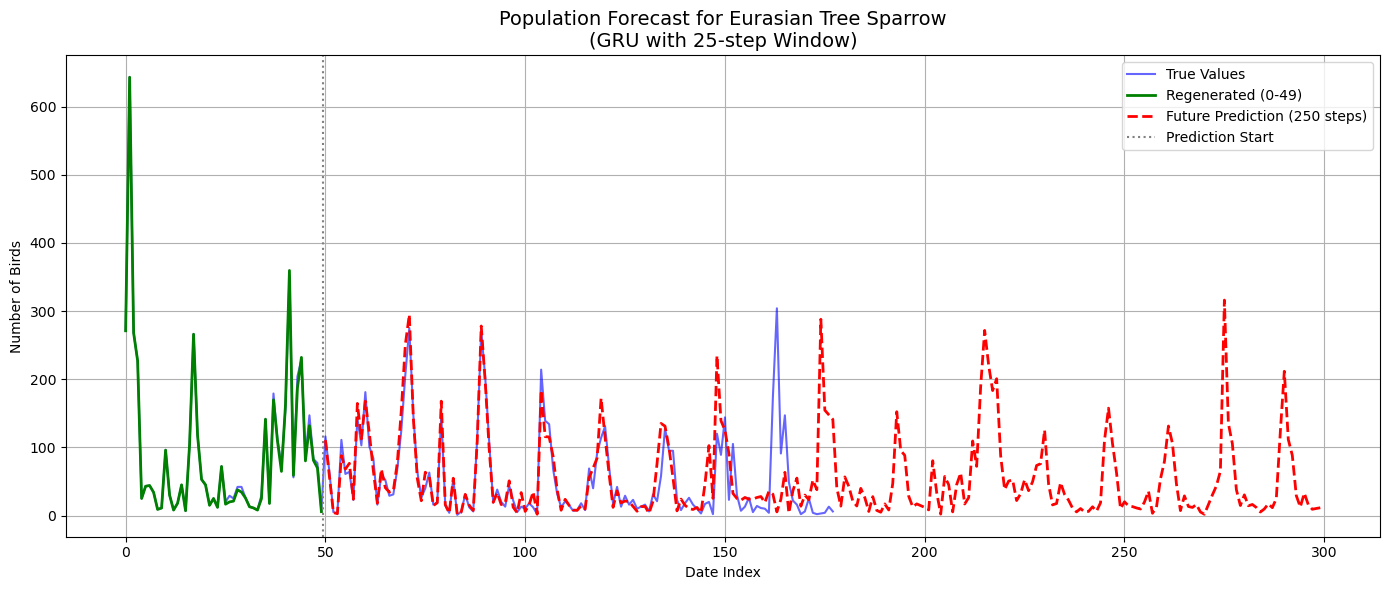

Model Performance Metrics of GRU with 25-step Window:
MSE: 42.3365
RMSE: 6.5067
MAE: 4.7496


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

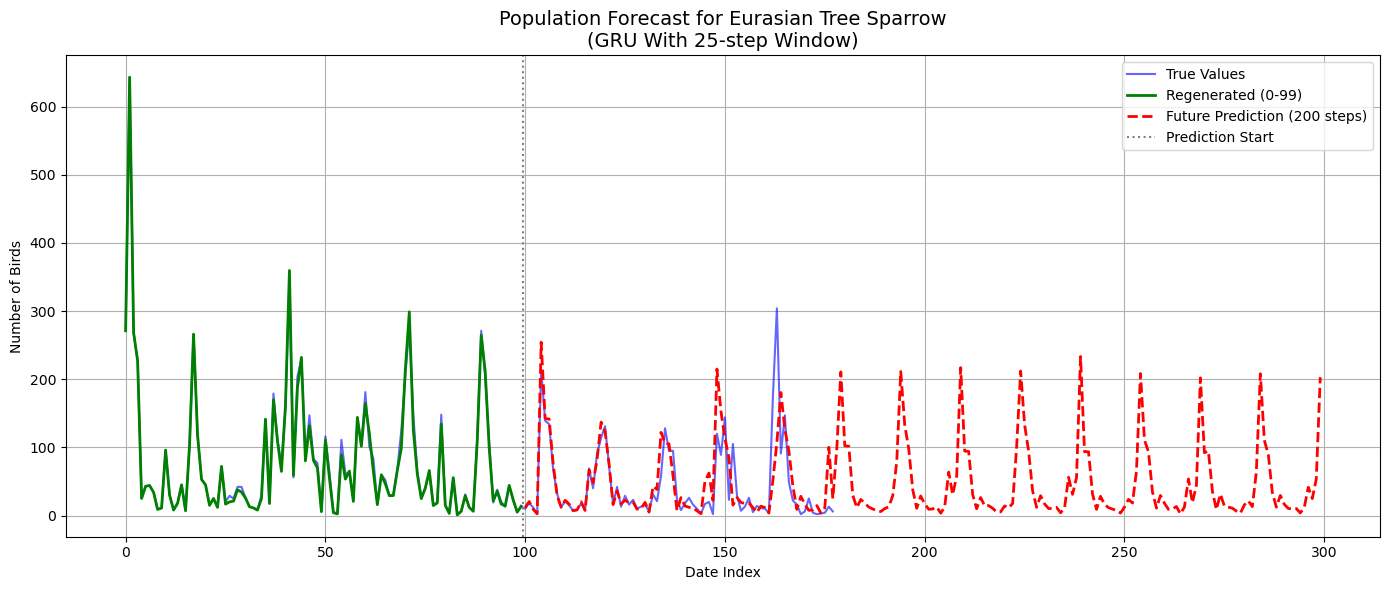

Model Performance Metrics of GRU with 25-step Window:
MSE: 66.8464
RMSE: 8.1760
MAE: 5.1008


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

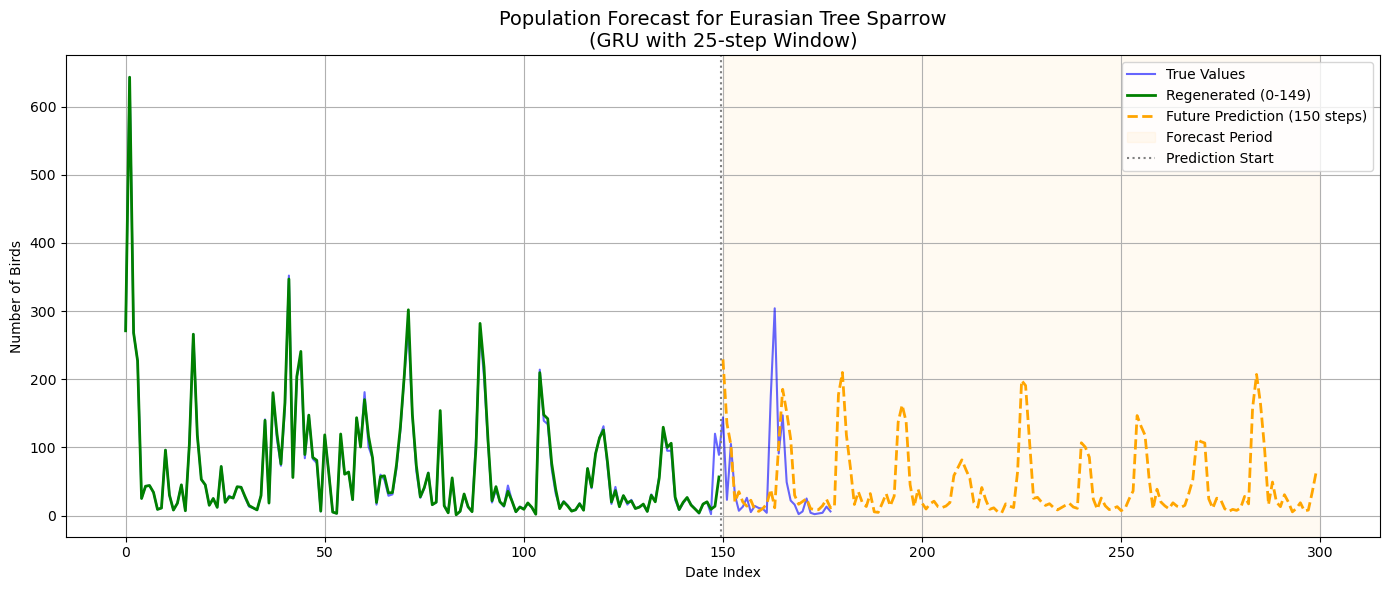

Model Performance Metrics of GRU with 25-step Window:
MSE: 123.1739
RMSE: 11.0984
MAE: 3.9611
MAPE: 9.39%


In [24]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 



print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


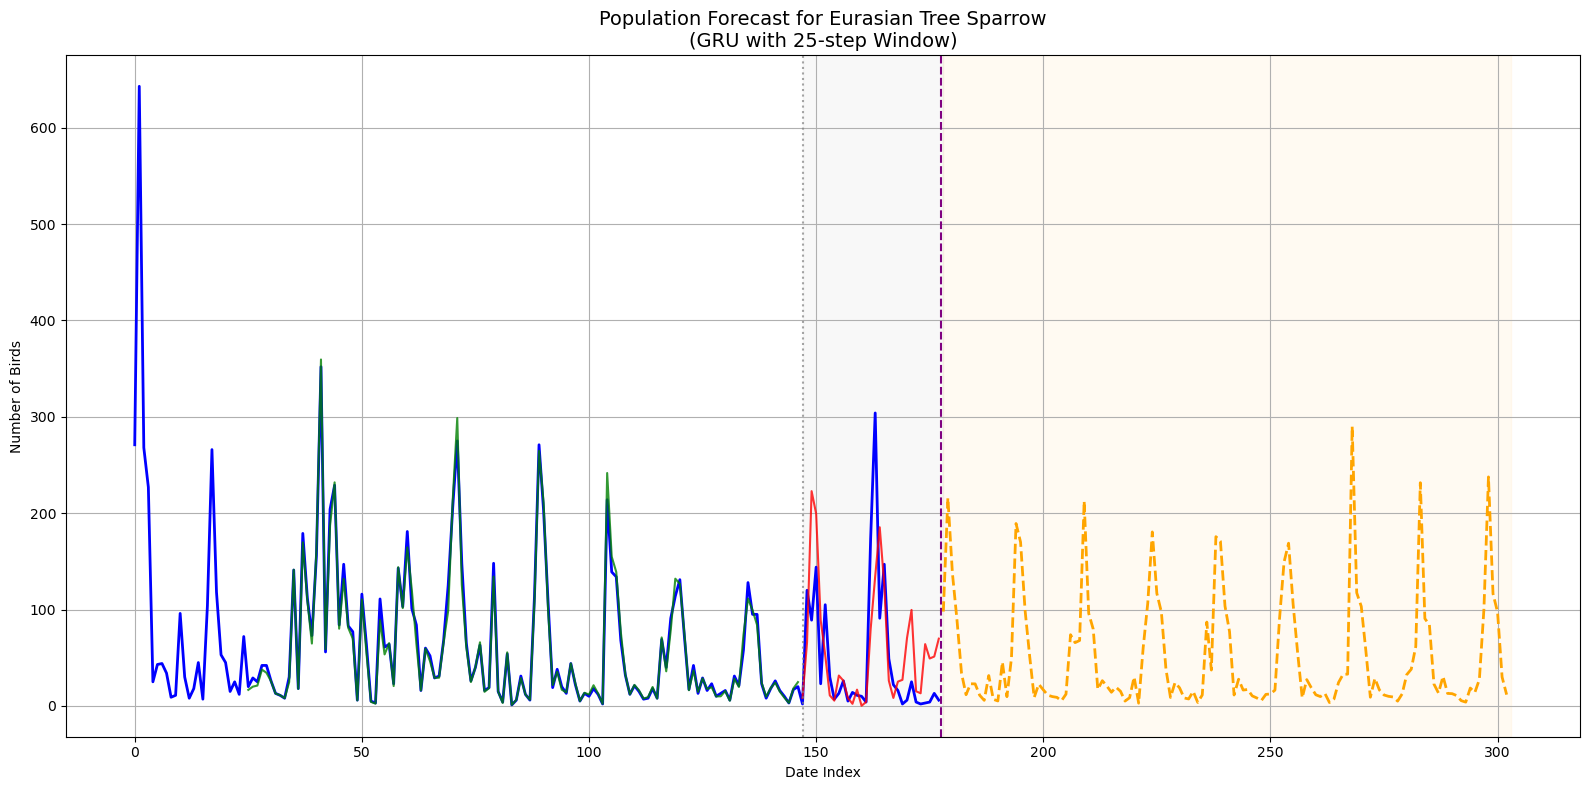


Model Performance Metrics of GRU with {window_size}-step Window:
Training RMSE: 7.81
Test RMSE: 57.28
Training MAE: 4.74
Test MAE: 40.57


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of GRU with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [35]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 97.90
Step 2: 215.91
Step 3: 137.61
Step 4: 89.41
Step 5: 34.01
Step 6: 11.65
Step 7: 22.96
Step 8: 22.88
Step 9: 11.08
Step 10: 5.78
Step 11: 31.51
Step 12: 6.85
Step 13: 5.14
Step 14: 45.48
Step 15: 9.57
Step 16: 49.76
Step 17: 189.30
Step 18: 169.98
Step 19: 98.95
Step 20: 51.76
Step 21: 8.78
Step 22: 22.52
Step 23: 16.72
Step 24: 11.15
Step 25: 9.67
Step 26: 8.88
Step 27: 5.33
Step 28: 12.20
Step 29: 73.88
Step 30: 65.65
Step 31: 67.89
Step 32: 212.57
Step 33: 96.09
Step 34: 79.57
Step 35: 17.22
Step 36: 26.19
Step 37: 20.54
Step 38: 14.18
Step 39: 19.48
Step 40: 15.22
Step 41: 5.03
Step 42: 8.49
Step 43: 29.96
Step 44: 2.83
Step 45: 60.78
Step 46: 106.60
Step 47: 180.55
Step 48: 116.76
Step 49: 97.35
Step 50: 38.42
Step 51: 8.80
Step 52: 24.17
Step 53: 18.78
Step 54: 8.29
Step 55: 7.22
Step 56: 15.07
Step 57: 3.61
Step 58: 11.34
Step 59: 87.01
Step 60: 37.22
Step 61: 175.65
Step 62: 170.78
Step 63: 103.67
Step 64: 77.14
Step 65: 11.33
Step 6

## **window size of 30**

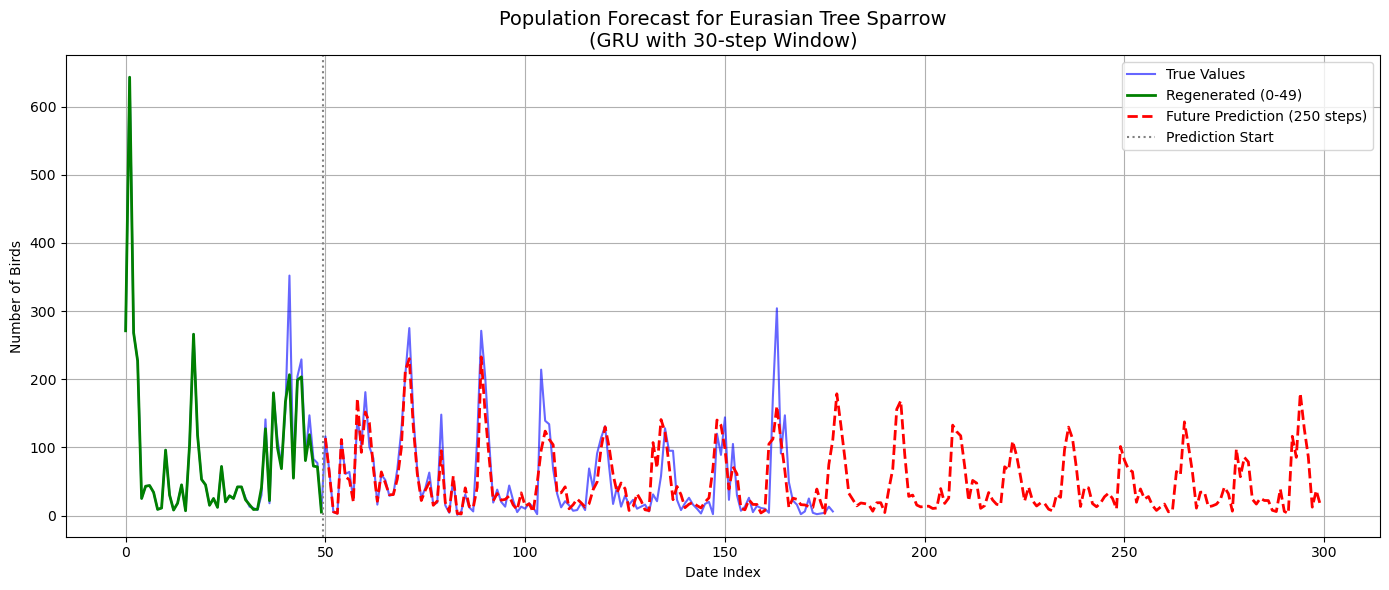

Model Performance Metrics of GRU with 30-step Window:
MSE: 1171.6051
RMSE: 34.2287
MAE: 14.6456


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

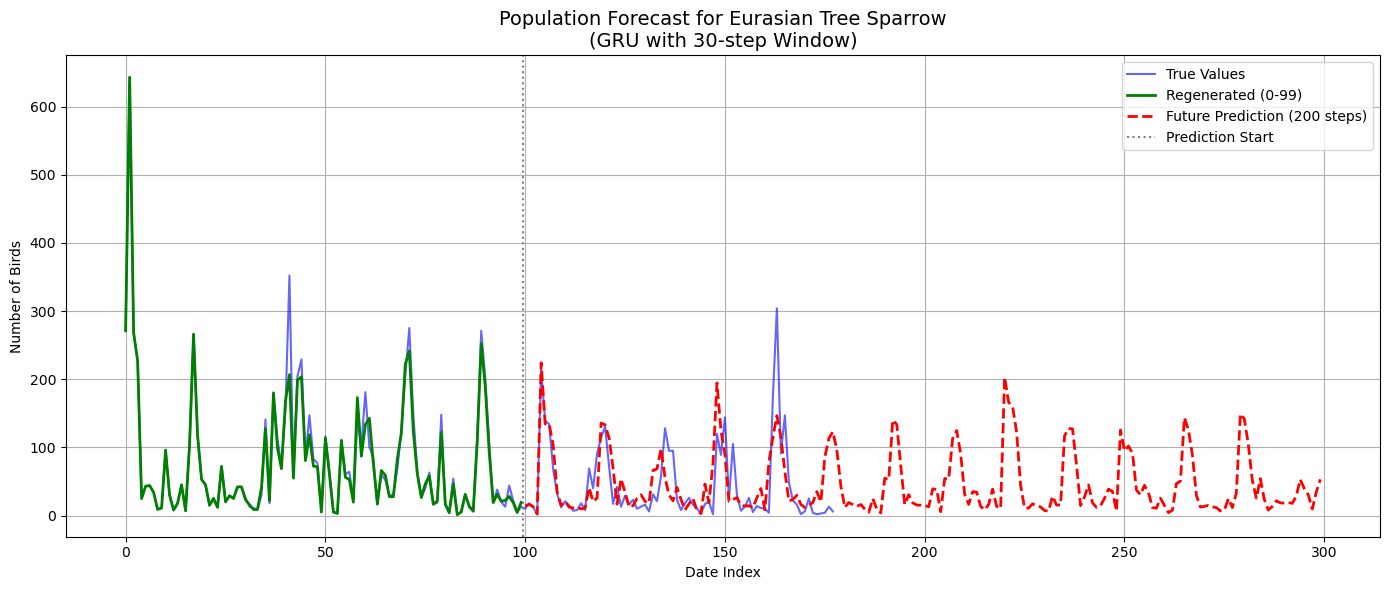

Model Performance Metrics of GRU with 30-step Window:
MSE: 473.8967
RMSE: 21.7692
MAE: 10.3877


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

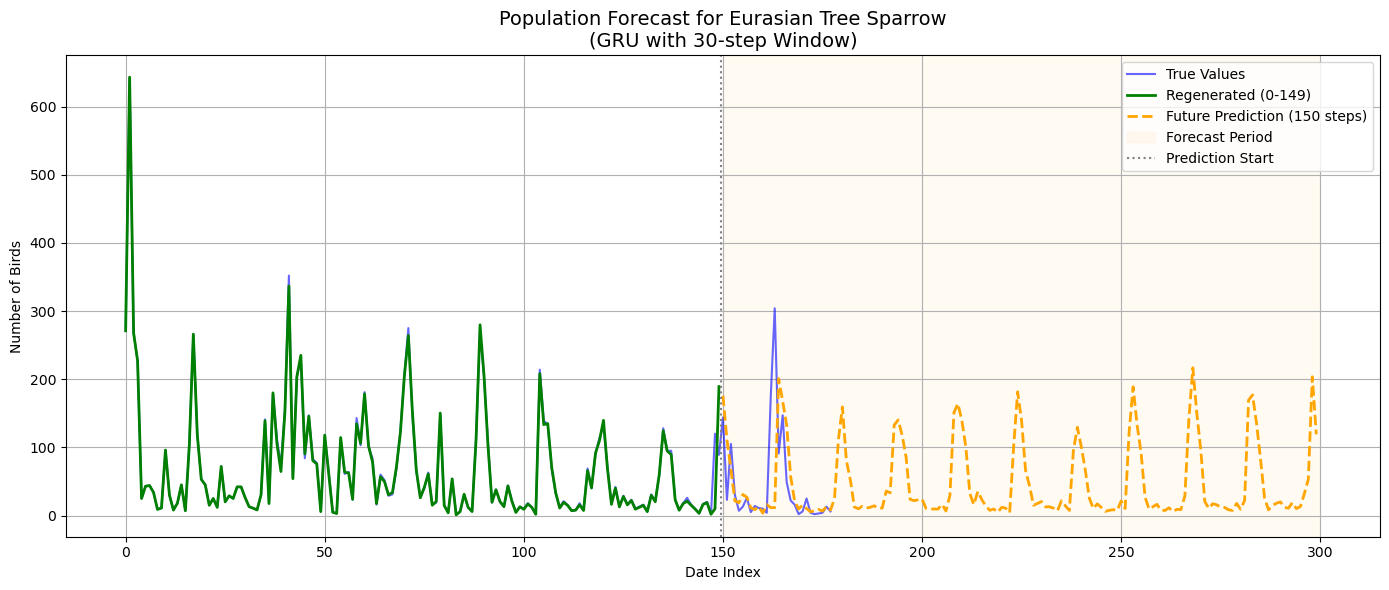

Model Performance Metrics of GRU with 30-step Window:
MSE: 194.8503
RMSE: 13.9589
MAE: 3.7281
MAPE: 5.52%


In [28]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 



print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


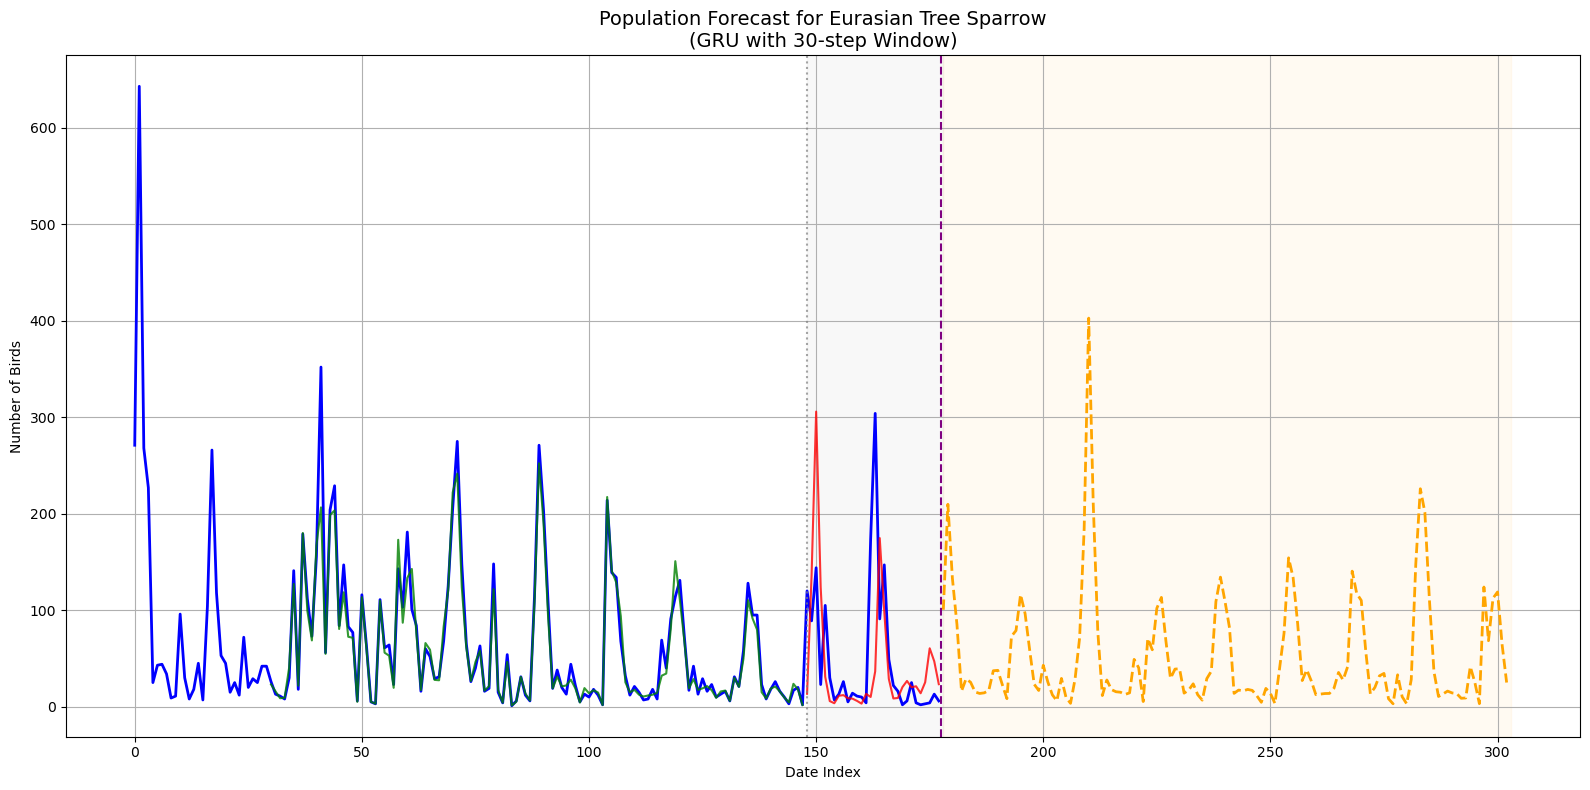


Model Performance Metrics of GRU with {window_size}-step Window:
Training RMSE: 18.06
Test RMSE: 75.53
Training MAE: 8.79
Test MAE: 45.71


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of GRU with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [43]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 100.51
Step 2: 209.82
Step 3: 132.81
Step 4: 85.10
Step 5: 16.05
Step 6: 28.89
Step 7: 25.34
Step 8: 15.30
Step 9: 13.73
Step 10: 14.38
Step 11: 16.78
Step 12: 37.28
Step 13: 37.70
Step 14: 22.63
Step 15: 8.36
Step 16: 73.01
Step 17: 78.95
Step 18: 116.28
Step 19: 96.44
Step 20: 59.00
Step 21: 23.28
Step 22: 16.82
Step 23: 42.91
Step 24: 25.64
Step 25: 12.31
Step 26: 6.13
Step 27: 29.31
Step 28: 9.82
Step 29: 3.50
Step 30: 28.75
Step 31: 71.34
Step 32: 184.50
Step 33: 402.75
Step 34: 210.17
Step 35: 78.03
Step 36: 11.56
Step 37: 27.69
Step 38: 17.75
Step 39: 15.52
Step 40: 15.02
Step 41: 12.72
Step 42: 14.37
Step 43: 49.04
Step 44: 40.36
Step 45: 5.36
Step 46: 70.77
Step 47: 59.00
Step 48: 102.07
Step 49: 113.29
Step 50: 68.00
Step 51: 29.36
Step 52: 39.01
Step 53: 39.31
Step 54: 14.08
Step 55: 17.16
Step 56: 23.72
Step 57: 12.42
Step 58: 6.79
Step 59: 29.13
Step 60: 36.90
Step 61: 108.93
Step 62: 134.30
Step 63: 109.32
Step 64: 81.67
Step 65: 13

## **Window Size of 50**

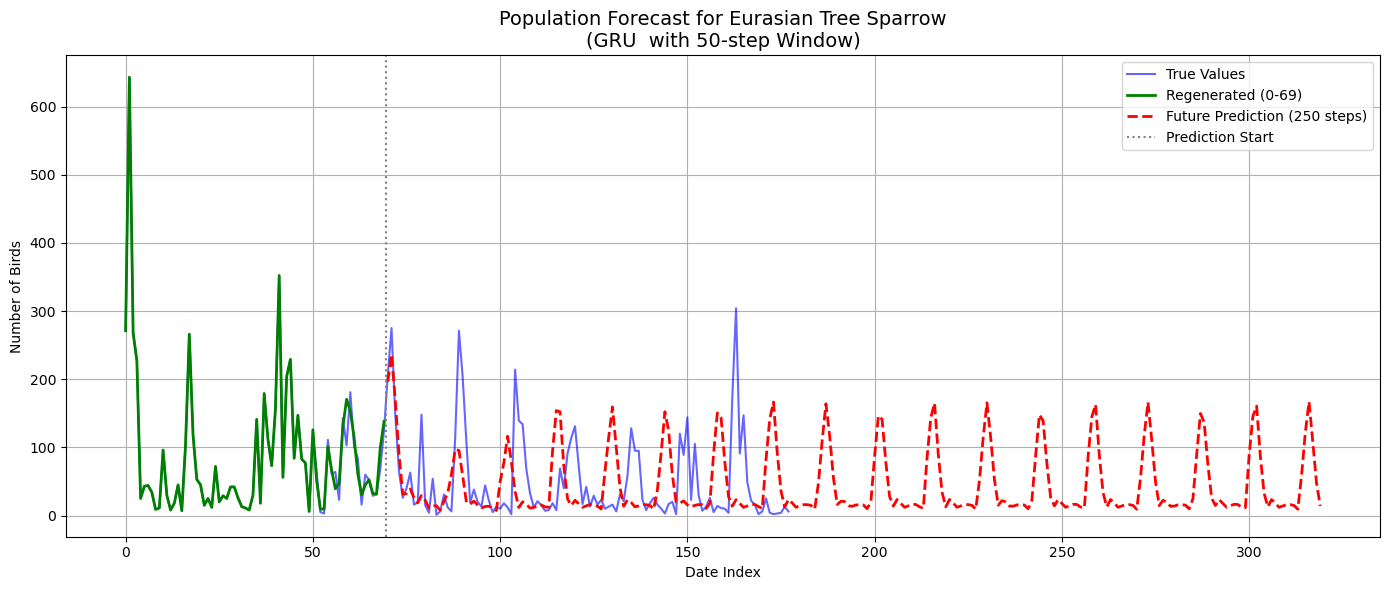

Model Performance Metrics of GRU with 50-step Window:
MSE: 474.1151
RMSE: 21.7742
MAE: 16.0866


In [ ]:
regenerate_points = 70
future_steps = 250

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

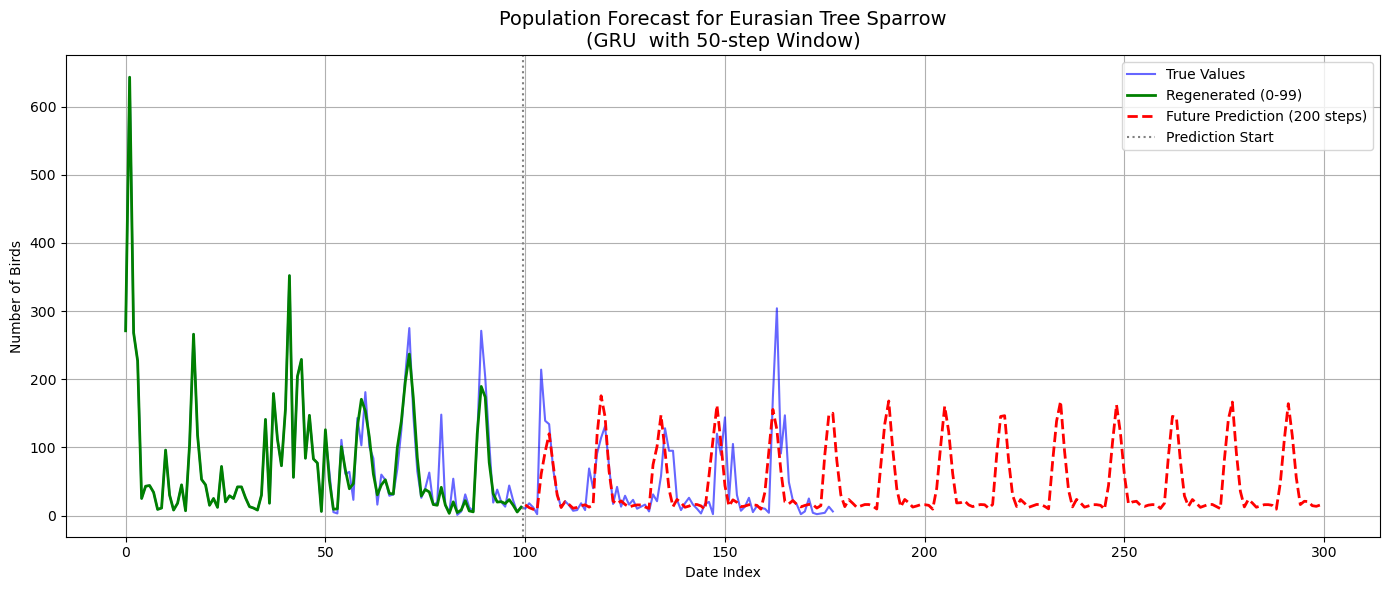

Model Performance Metrics of GRU with 50-step Window:
MSE: 698.4619
RMSE: 26.4284
MAE: 16.4904


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

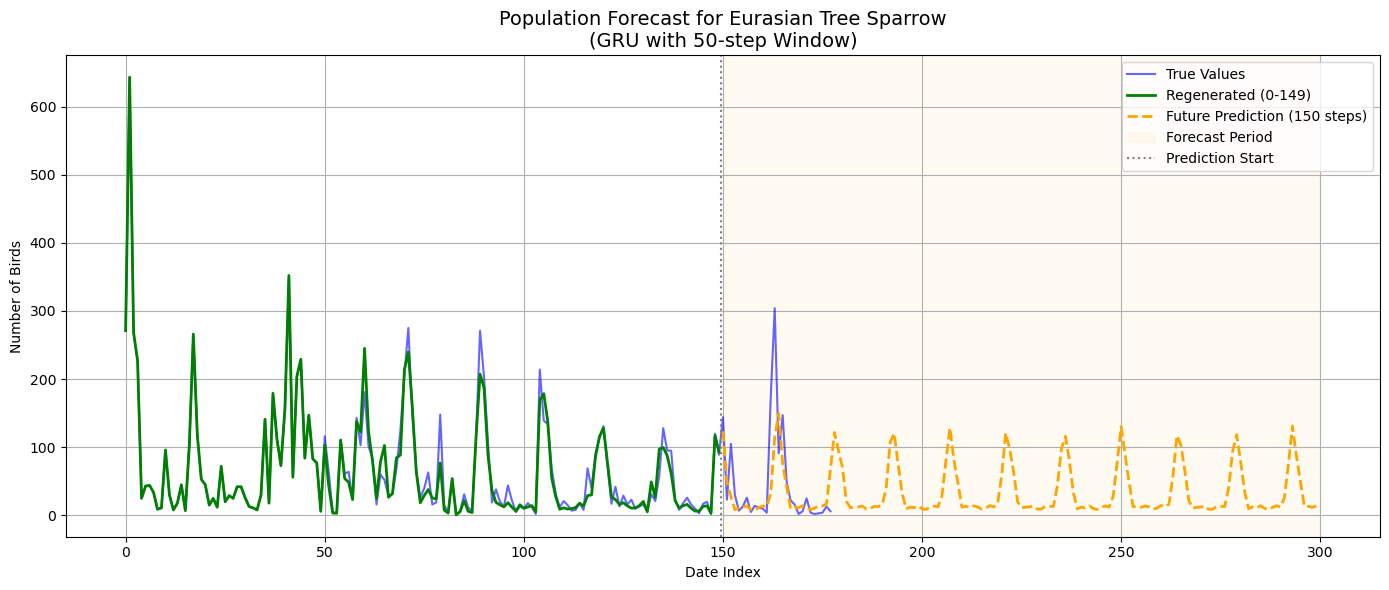

Model Performance Metrics of GRU with 50-step Window:
MSE: 348.4283
RMSE: 18.6662
MAE: 11.5716
MAPE: 28.60%


In [32]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 



print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


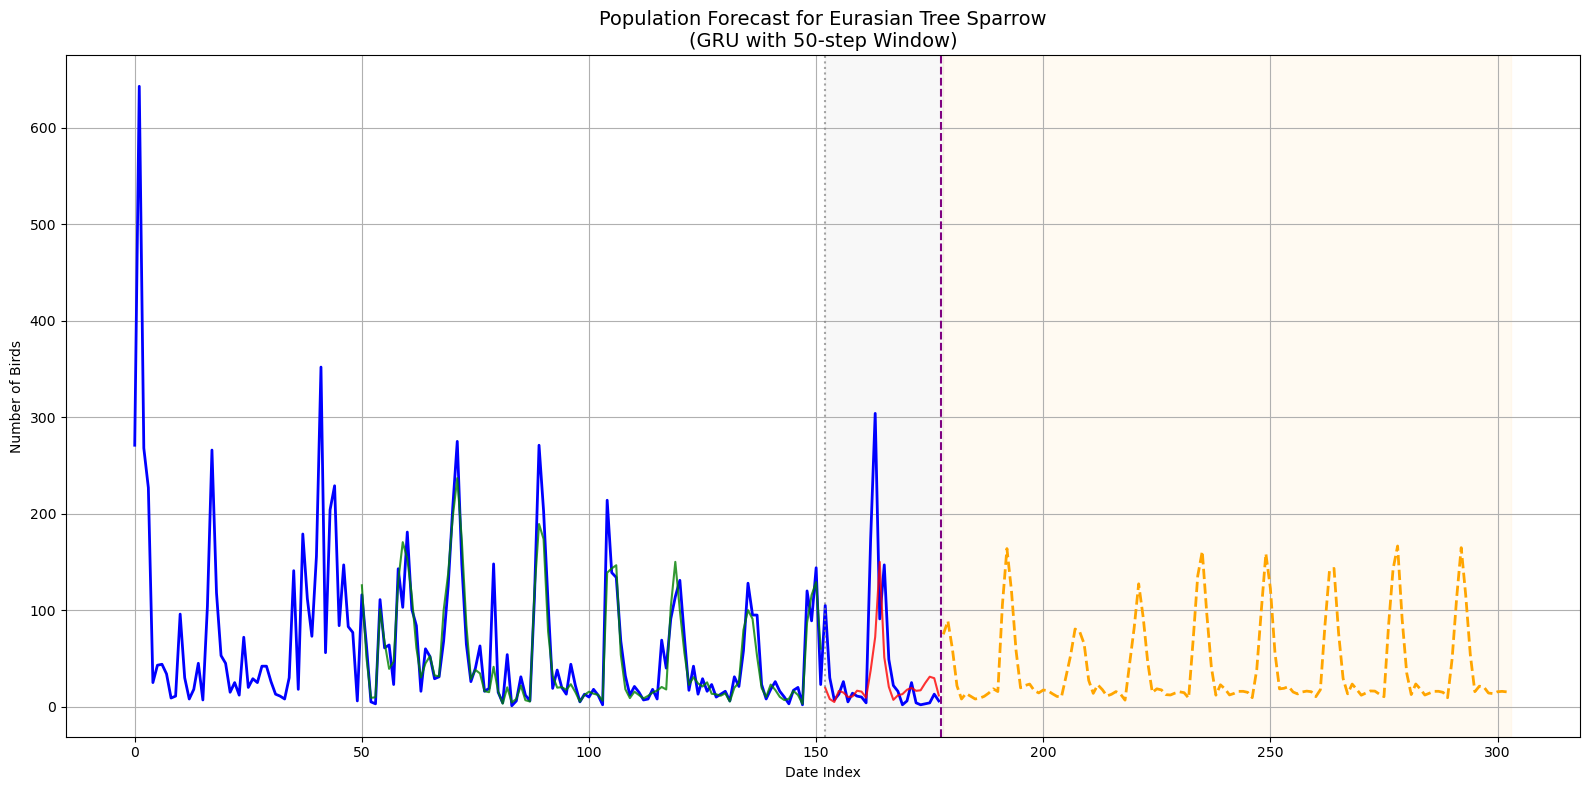


Model Performance Metrics of GRU with {window_size}-step Window:
Training RMSE: 23.08
Test RMSE: 60.84
Training MAE: 14.53
Test MAE: 32.55


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of GRU with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [16]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 75.02
Step 2: 88.90
Step 3: 59.84
Step 4: 21.70
Step 5: 7.99
Step 6: 13.73
Step 7: 10.89
Step 8: 8.01
Step 9: 8.84
Step 10: 10.77
Step 11: 14.13
Step 12: 18.54
Step 13: 15.71
Step 14: 105.45
Step 15: 163.89
Step 16: 120.03
Step 17: 58.51
Step 18: 19.57
Step 19: 21.99
Step 20: 23.47
Step 21: 16.81
Step 22: 14.29
Step 23: 17.35
Step 24: 16.59
Step 25: 13.48
Step 26: 10.70
Step 27: 10.10
Step 28: 31.21
Step 29: 52.76
Step 30: 80.53
Step 31: 77.93
Step 32: 65.15
Step 33: 27.38
Step 34: 13.82
Step 35: 22.70
Step 36: 17.72
Step 37: 11.14
Step 38: 12.85
Step 39: 15.68
Step 40: 13.12
Step 41: 6.83
Step 42: 44.37
Step 43: 81.43
Step 44: 127.38
Step 45: 92.48
Step 46: 45.91
Step 47: 14.74
Step 48: 18.53
Step 49: 17.43
Step 50: 12.53
Step 51: 12.15
Step 52: 14.11
Step 53: 15.44
Step 54: 14.55
Step 55: 8.96
Step 56: 69.71
Step 57: 135.53
Step 58: 161.13
Step 59: 96.02
Step 60: 41.12
Step 61: 11.96
Step 62: 22.73
Step 63: 18.43
Step 64: 12.20
Step 65: 13.77
S

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 50, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,917 (261.40 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,612 (174.27 KB)